In [1]:
import dataframe_image as dfi
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (GridSearchCV, cross_validate,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.features import rank1d
from yellowbrick.target import FeatureCorrelation

In [2]:
data = pd.read_csv("../Occupancy_Estimation.csv")
data.columns = data.columns.str.strip().str.lower()
data.insert(2, "datetime", pd.to_datetime(data["date"] + " " + data["time"]))
data["room_occupancy_count"] = data["room_occupancy_count"].astype(int)
data = data.iloc[:, 2:]
data.head()

,datetime,s1_temp,s2_temp,s3_temp,s4_temp,s1_light,s2_light,s3_light,s4_light,s1_sound,s2_sound,s3_sound,s4_sound,s5_co2,s5_co2_slope,s6_pir,s7_pir,room_occupancy_count
0,2017-12-22 10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017-12-22 10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017-12-22 10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017-12-22 10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017-12-22 10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              10129 non-null  datetime64[ns]
 1   s1_temp               10129 non-null  float64       
 2   s2_temp               10129 non-null  float64       
 3   s3_temp               10129 non-null  float64       
 4   s4_temp               10129 non-null  float64       
 5   s1_light              10129 non-null  int64         
 6   s2_light              10129 non-null  int64         
 7   s3_light              10129 non-null  int64         
 8   s4_light              10129 non-null  int64         
 9   s1_sound              10129 non-null  float64       
 10  s2_sound              10129 non-null  float64       
 11  s3_sound              10129 non-null  float64       
 12  s4_sound              10129 non-null  float64       
 13  s5_co2          

In [4]:
X, y = (
    data.drop(["room_occupancy_count", "datetime"], axis=1),
    data["room_occupancy_count"],
)

/Users/raja_/Documents/GitHub/msds_winter_2022/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


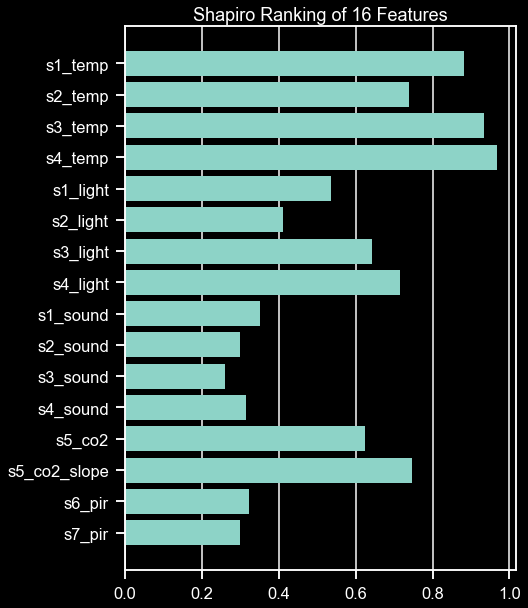

<AxesSubplot:title={'center':'Shapiro Ranking of 16 Features'}>

In [5]:
sns.set_context("talk")
plt.figure(figsize=(7, 10))
rank1d(X, y).show()

In [6]:
# Do a 70-20-10 split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.333333)

In [7]:
for dat, dat_name in [
    (X_train, "X_train"),
    (X_test, "X_test"),
    (X_val, "X_validatation"),
    (y_train, "y_train"),
    (y_test, "y_test"),
    (y_val, "y_validation"),
]:
    print(dat_name)
    print(dat.shape[0])
    print(f"{dat.shape[0]/len(data):.0%} of data")
    print()

X_train
7090
70% of data

X_test
2026
20% of data

X_validatation
1013
10% of data

y_train
7090
70% of data

y_test
2026
20% of data

y_validation
1013
10% of data



Text(0, 0.5, 'Support')

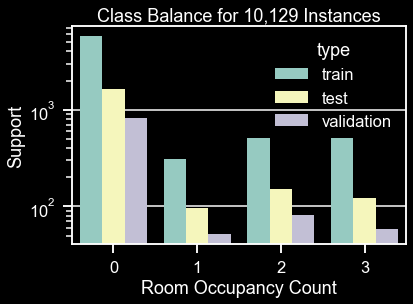

In [8]:
# Create a dataframe of train, test, validation outcomes
outcomes_df = pd.DataFrame()
for dat in [("train", y_train), ("test", y_test), ("validation", y_val)]:
    df = pd.DataFrame(dat[1].values)
    df['type'] = dat[0]
    outcomes_df = pd.concat([outcomes_df, df])
outcomes_df.rename(columns={0: "room_occupancy_count"}, inplace=True)
outcomes_df

sns.countplot(
    x="room_occupancy_count",
    y=None,
    hue="type",
    data=outcomes_df,
    order=None
)
plt.title("Class Balance for 10,129 Instances")
plt.yscale("log")
plt.xlabel("Room Occupancy Count")
plt.ylabel("Support")

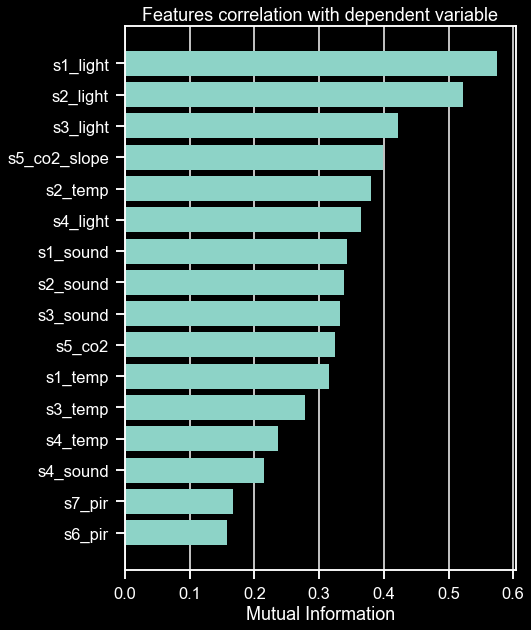

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [9]:
# Instaniate the visualizer
visualizer = FeatureCorrelation(method="mutual_info-classification", sort=True)
plt.figure(figsize=(7, 10))
visualizer.fit(X, y)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [10]:
stats = data.drop(columns=["room_occupancy_count", "datetime"]).agg(["mean", "std", "median", "min", "max"]).round(2)
display(stats)
dfi.export(stats, "../stats.png")

,s1_temp,s2_temp,s3_temp,s4_temp,s1_light,s2_light,s3_light,s4_light,s1_sound,s2_sound,s3_sound,s4_sound,s5_co2,s5_co2_slope,s6_pir,s7_pir
mean,25.45,25.55,25.06,25.75,25.45,26.02,34.25,13.22,0.17,0.12,0.16,0.10,460.86,-0.00,0.09,0.08
std,0.35,0.59,0.43,0.36,51.01,67.30,58.40,19.60,0.32,0.27,0.41,0.12,199.96,1.16,0.29,0.27
median,25.38,25.38,24.94,25.75,0.00,0.00,0.00,0.00,0.08,0.05,0.06,0.08,360.00,0.00,0.00,0.00
min,24.94,24.75,24.44,24.94,0.00,0.00,0.00,0.00,0.06,0.04,0.04,0.05,345.00,-6.30,0.00,0.00
max,26.38,29.00,26.19,26.56,165.00,258.00,280.00,74.00,3.88,3.44,3.67,3.40,1270.00,8.98,1.00,1.00


[0313/170027.182021:INFO:headless_shell.cc(659)] Written to file /var/folders/3c/mdbs2nh57lb084xrksjwy50w0000gn/T/tmp1af3z57e/temp.png.


Text(0.5, 0, 'Temperature')

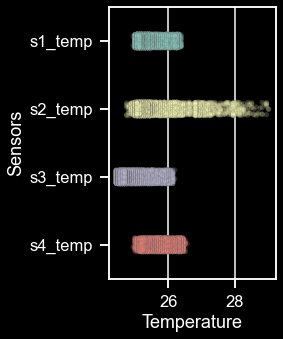

In [11]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[[col for col in data.columns if "temp" in col]].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("Sensors")
plt.xlabel("Temperature")

Text(0.5, 0, 'Light')

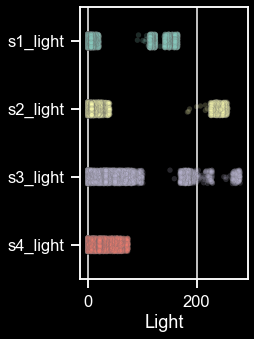

In [12]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[[col for col in data.columns if "light" in col]].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("")
plt.xlabel("Light")

Text(0.5, 0, 'sound')

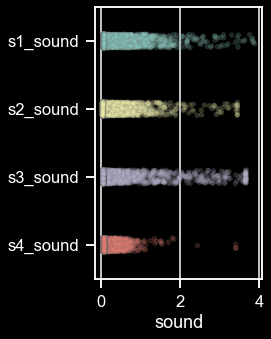

In [13]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[[col for col in data.columns if "sound" in col]].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("")
plt.xlabel("sound")

Text(0.5, 0, 'PIR')

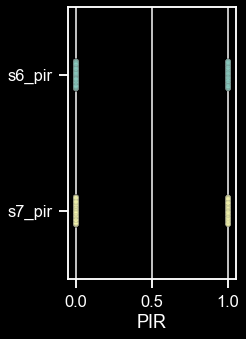

In [14]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[[col for col in data.columns if "pir" in col and "slope" not in col]].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("")
plt.xlabel("PIR")

In [15]:
from sklearn.metrics import confusion_matrix

models = [
    RandomForestRegressor(), 
    Ridge(),
    LinearRegression(),
    DecisionTreeRegressor(),
]

data = [
    ("Train", X_train, y_train),
    ("Test", X_test, y_test),
    ("Validation", X_val, y_val)
]


def transform_predictions(pred_array):
    """Transforms occupancy predictions into discrete values which match expected possible outcomes.
    Rounds predicted value to nearest integer unless predicted value is greater than 3. In which case, assigns 3.
    """
    new_preds = []
    for x in pred_array:
        if x < 1:
            new_preds.append(0)
        elif x < 2:
            new_preds.append(1)
        elif x < 3:
            new_preds.append(2)
        else:
            new_preds.append(3)
    return new_preds


for model in models:
    model_name = model.__class__.__name__

    model = Pipeline([("standardization", StandardScaler()), (model_name, model)])

    model.fit(X_train, y_train)

    print(model_name)

    for dat_name, x_dat, y_dat in data:
        print(dat_name, "Data Results:")
        print(f"   - RMSE: {mean_squared_error(y_dat, transform_predictions(model.predict(x_dat)), squared=False):.3f}")
        display(confusion_matrix(y_dat, transform_predictions(model.predict(x_dat))))
        print()

    print("-" * 50)


for model in models:
    model_PCA = Pipeline(
        [("standardization", StandardScaler()), ("pca", PCA(n_components=2)), (model.__class__.__name__, model)]
    )
    model_PCA.fit(X_train, y_train)
    print(model.__class__.__name__, "with PCA (n components = 2)")
    for dat_name, x_dat, y_dat in data:
        print(dat_name, "Data Results:")
        print(
            f"   - RMSE: {mean_squared_error(y_dat, transform_predictions(model_PCA.predict(x_dat)), squared=False):.3f}"
        )
        
        display(confusion_matrix(y_dat, transform_predictions(model_PCA.predict(x_dat))))
        print()
    print("-" * 50)

RandomForestRegressor
Train Data Results:
   - RMSE: 0.146


array([[5751,    0,    0,    0],
       [   5,  306,    0,    0],
       [   0,   35,  479,    0],
       [   0,    1,  108,  405]])


Test Data Results:
   - RMSE: 0.165


array([[1656,    0,    0,    0],
       [   2,   94,    0,    0],
       [   0,   16,  137,    0],
       [   0,    1,   33,   87]])


Validation Data Results:
   - RMSE: 0.166


array([[820,   1,   0,   0],
       [  0,  52,   0,   0],
       [  0,   5,  76,   0],
       [  0,   1,  18,  40]])


--------------------------------------------------
Ridge
Train Data Results:
   - RMSE: 0.419


array([[5738,   13,    0,    0],
       [ 163,  148,    0,    0],
       [   2,  248,  249,   15],
       [  13,  108,  247,  146]])


Test Data Results:
   - RMSE: 0.408


array([[1652,    4,    0,    0],
       [  50,   45,    1,    0],
       [   0,   87,   60,    6],
       [   2,   28,   60,   31]])


Validation Data Results:
   - RMSE: 0.429


array([[819,   2,   0,   0],
       [ 28,  23,   1,   0],
       [  1,  43,  37,   0],
       [  1,  17,  31,  10]])


--------------------------------------------------
LinearRegression
Train Data Results:
   - RMSE: 0.419


array([[5738,   13,    0,    0],
       [ 163,  148,    0,    0],
       [   2,  248,  249,   15],
       [  13,  108,  247,  146]])


Test Data Results:
   - RMSE: 0.408


array([[1652,    4,    0,    0],
       [  50,   45,    1,    0],
       [   0,   87,   60,    6],
       [   2,   28,   60,   31]])


Validation Data Results:
   - RMSE: 0.429


array([[819,   2,   0,   0],
       [ 28,  23,   1,   0],
       [  1,  43,  37,   0],
       [  1,  17,  31,  10]])


--------------------------------------------------
DecisionTreeRegressor
Train Data Results:
   - RMSE: 0.000


array([[5751,    0,    0,    0],
       [   0,  311,    0,    0],
       [   0,    0,  514,    0],
       [   0,    0,    0,  514]])


Test Data Results:
   - RMSE: 0.074


array([[1656,    0,    0,    0],
       [   0,   93,    3,    0],
       [   0,    1,  149,    3],
       [   0,    0,    4,  117]])


Validation Data Results:
   - RMSE: 0.109


array([[821,   0,   0,   0],
       [  0,  52,   0,   0],
       [  0,   0,  81,   0],
       [  1,   0,   3,  55]])


--------------------------------------------------
RandomForestRegressor with PCA (n components = 2)
Train Data Results:
   - RMSE: 0.289


array([[5747,    4,    0,    0],
       [  90,  221,    0,    0],
       [   0,  102,  412,    0],
       [   0,    4,  380,  130]])


Test Data Results:
   - RMSE: 0.338


array([[1650,    4,    2,    0],
       [  34,   50,   12,    0],
       [   4,   33,  115,    1],
       [   0,    7,   95,   19]])


Validation Data Results:
   - RMSE: 0.347


array([[818,   2,   1,   0],
       [ 20,  31,   1,   0],
       [  1,  21,  58,   1],
       [  0,   6,  45,   8]])


--------------------------------------------------
Ridge with PCA (n components = 2)
Train Data Results:
   - RMSE: 0.518


array([[5720,   27,    1,    3],
       [ 194,  115,    2,    0],
       [   0,  311,  173,   30],
       [  52,  160,  198,  104]])


Test Data Results:
   - RMSE: 0.485


array([[1646,   10,    0,    0],
       [  59,   36,    1,    0],
       [   0,   83,   66,    4],
       [  13,   38,   51,   19]])


Validation Data Results:
   - RMSE: 0.511


array([[816,   4,   0,   1],
       [ 38,  13,   1,   0],
       [  0,  52,  25,   4],
       [  7,  19,  17,  16]])


--------------------------------------------------
LinearRegression with PCA (n components = 2)
Train Data Results:
   - RMSE: 0.518


array([[5720,   27,    1,    3],
       [ 194,  115,    2,    0],
       [   0,  311,  173,   30],
       [  52,  160,  198,  104]])


Test Data Results:
   - RMSE: 0.485


array([[1646,   10,    0,    0],
       [  59,   36,    1,    0],
       [   0,   83,   66,    4],
       [  13,   38,   51,   19]])


Validation Data Results:
   - RMSE: 0.511


array([[816,   4,   0,   1],
       [ 38,  13,   1,   0],
       [  0,  52,  25,   4],
       [  7,  19,  17,  16]])


--------------------------------------------------
DecisionTreeRegressor with PCA (n components = 2)
Train Data Results:
   - RMSE: 0.000


array([[5751,    0,    0,    0],
       [   0,  311,    0,    0],
       [   0,    0,  514,    0],
       [   0,    0,    0,  514]])


Test Data Results:
   - RMSE: 0.303


array([[1640,   11,    1,    4],
       [   4,   78,    6,    8],
       [   4,    3,  125,   21],
       [   1,    6,   20,   94]])


Validation Data Results:
   - RMSE: 0.323


array([[816,   2,   0,   3],
       [  6,  41,   3,   2],
       [  3,   4,  66,   8],
       [  0,   6,  12,  41]])


--------------------------------------------------


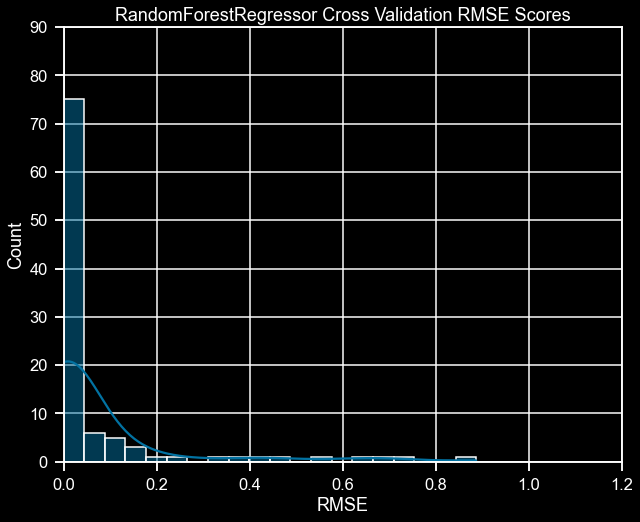

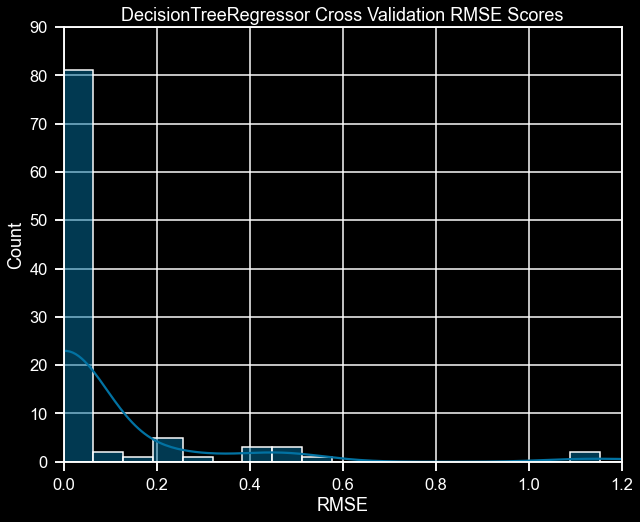

In [16]:
models = [
    RandomForestRegressor(max_depth=10), 
    DecisionTreeRegressor(max_depth=10),
]

for model in models:
    scores = cross_validate(model, X, y, cv=100, scoring=('neg_mean_squared_error'), n_jobs=-1)['test_score']
    scores *= -1
    scores **= (1/2)

    plt.figure(figsize=(10,8))
    sns.histplot(scores, bins=20, kde=True)
    plt.title(f"{model.__class__.__name__} Cross Validation RMSE Scores")
    plt.xlabel("RMSE")
    plt.xlim(0, 1.2)
    plt.ylim(0, 90)
    plt.show()

In [17]:
# Set up a model with a pipeline containing a gridsearch for PCA and gridsearch for random forest classifier

pca_grid = GridSearchCV(estimator=PCA(), param_grid={"n_components": [2, len(X_train.columns)]})

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(), param_grid={"n_estimators": range(20, 100, 10)}, cv=10, n_jobs=-1
)

model = Pipeline([("PCA", pca_grid), ("RF", rf_grid)])

model.fit(X_train, y_train)
print(model.__class__.__name__)
for dat_name, x_dat, y_dat in data:
        print(dat_name, "Data Results:")
        print(
            f"   - MSE: {mean_squared_error(y_dat, transform_predictions(model.predict(x_dat)), squared=False):.3f}"
        )
        print()
print("-" * 50)

In [ ]:
model["RF"].best_params_

In [ ]:
pca = PCA()
pca.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance vs. Number of Components")
plt.ylabel("Explained Variance")
plt.xlabel("Number of Components")
plt.show()